# **0. Initial Setup and Library Imports**

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [2]:
# Built-in/utilities
import math
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

# Data handling
import numpy as np
import pandas as pd

# Sci/stats
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import seaborn as sns

# Scikit-learn: preprocessing, model selection, models, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
!mkdir -p /usr/share/fonts/truetype/poppins
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf -P /usr/share/fonts/truetype/poppins/
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf -P /usr/share/fonts/truetype/poppins/
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Italic.ttf -P /usr/share/fonts/truetype/poppins/

font_dir = '/usr/share/fonts/truetype/poppins'
for font_file in fm.findSystemFonts(fontpaths=[font_dir]):
    fm.fontManager.addfont(font_file)

In [4]:
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
palette = ['#496af1', '#BFBFBF', '#e6e51e', '#4a4a4a']

plt.rcParams['font.family'] = 'Poppins'

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['text.color'] = '#808080'
plt.rcParams['axes.labelcolor'] = '#808080'
plt.rcParams['axes.titlecolor'] = '#808080'
plt.rcParams['xtick.labelcolor'] = '#808080'
plt.rcParams['ytick.labelcolor'] = '#808080'

plt.rcParams['xtick.color'] = '#BFBFBF'
plt.rcParams['ytick.color'] = '#BFBFBF'
plt.rcParams['axes.edgecolor'] = '#BFBFBF'
plt.rcParams['grid.color'] = '#BFBFBF'

gray_props = {
    "boxprops": dict(color="#808080"),
    "medianprops": dict(color="#808080"),
    "whiskerprops": dict(color="#808080"),
    "capprops": dict(color="#808080"),
    "flierprops": dict(marker='o', markeredgecolor="#808080", markersize=5)
}

# **1. Data Loading**

In [66]:
# Load dataset from CSV
df = pd.read_csv('Clicked Ads Dataset.csv')
display(df.head())

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,0,68.95,35,"432,837,300.00",256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,1,80.23,31,"479,092,950.00",193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,2,69.47,26,"418,501,580.00",236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,3,74.15,29,"383,643,260.00",245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,4,68.37,35,"517,229,930.00",225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [67]:
# Define categorical and numerical columns
cat_cols = ['Male', 'Clicked on Ad', 'city', 'province', 'category']
num_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Timestamp']

In [68]:
# Show dataset info (dtypes, nulls, memory usage)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   Daily Time Spent on Site  987 non-null    float64
 2   Age                       1000 non-null   int64  
 3   Area Income               987 non-null    float64
 4   Daily Internet Usage      989 non-null    float64
 5   Male                      997 non-null    object 
 6   Timestamp                 1000 non-null   object 
 7   Clicked on Ad             1000 non-null   object 
 8   city                      1000 non-null   object 
 9   province                  1000 non-null   object 
 10  category                  1000 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 86.1+ KB
None


In [69]:
# Summary statistics for numerical and categorical columns
display(df[num_cols].describe().T)
display(df[cat_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,987.00,64.93,15.84,32.60,51.27,68.11,78.46,91.43
Age,"1,000.00",36.01,8.79,19.00,29.00,35.00,42.00,61.00
Area Income,987.00,"384,864,670.64","94,079,989.57","97,975,500.00","328,632,990.00","399,068,320.00","458,355,450.00","556,393,600.00"


,count,unique,top,freq
Male,997,2,Perempuan,518
Clicked on Ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


# **2. Feature Engineering**

### **2.1. Numerical Feature Engineering**

In [70]:
# Ratio feature: site time vs internet usage
df['time_usage_ratio'] = df['Daily Time Spent on Site'] / (df['Daily Internet Usage'] + 1)

# Age binning into groups
bins = pd.qcut(df['Age'], q=5)
labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in bins.cat.categories]
df['age_group'] = pd.qcut(df['Age'], q=5, labels=labels)

### **2.2. Temporal Features**

In [71]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract basic time features
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek

### **2.3. Column Name Cleaning**

In [72]:
# Clean column names: trim, lowercase, replace spaces/symbols with _
df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True))

# **3. Data Preprocessing**

## **3.1. Split Dataset**

In [73]:
# Train-Test Split
X = df.drop(columns="clicked_on_ad")
y = df["clicked_on_ad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [74]:
cat_cols = ['male', 'city', 'province', 'category', 'age_group', 'hour', 'day_of_week', 'is_weekend']
num_cols = ['daily_time_spent_on_site', 'age', 'area_income', 'daily_internet_usage', 'time_usage_ratio']

## **3.2. Drop Unnecessary Columns**

In [75]:
# Drop unnecessary columns
X_train = X_train.drop(['unnamed_0', 'timestamp'], axis=1)
X_test = X_test.drop(['unnamed_0', 'timestamp'], axis=1)

## **3.3. Handle Missing Values**

In [76]:
missing_before_train = X_train.isnull().sum()
missing_before_test = X_train.isnull().sum()
print('Missing values in train set:', missing_before_train[missing_before_train > 0])
print('\nMissing values in tes set:', missing_before_test[missing_before_test > 0])

Missing values in train set: daily_time_spent_on_site    12
area_income                 11
daily_internet_usage         7
male                         3
time_usage_ratio            18
dtype: int64

Missing values in tes set: daily_time_spent_on_site    12
area_income                 11
daily_internet_usage         7
male                         3
time_usage_ratio            18
dtype: int64


In [77]:
# Handle missing values for numerical columns
for col in num_cols:
    if col in X_train.columns and X_train[col].isnull().any():
        median_value = X_train[col].median()

        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)

        print(f"Filled {col} with median from train: {median_value:.2f}")

Filled daily_time_spent_on_site with median from train: 68.33
Filled area_income with median from train: 400371720.00
Filled daily_internet_usage with median from train: 183.48
Filled time_usage_ratio with median from train: 0.36


In [78]:
# Handle missing values for categorical columns
for col in cat_cols:
    if col in X_train.columns:
        mode_value = X_train[col].mode()[0]

        X_train[col].fillna(mode_value, inplace=True)
        X_test[col].fillna(mode_value, inplace=True)

        print(f"Filled {col} with mode: {mode_value}")

Filled male with mode: Perempuan
Filled city with mode: Bandung
Filled province with mode: Daerah Khusus Ibukota Jakarta
Filled category with mode: Fashion
Filled age_group with mode: 37–44
Filled hour with mode: 20
Filled day_of_week with mode: 4


## **3.4. Handle Outliers**

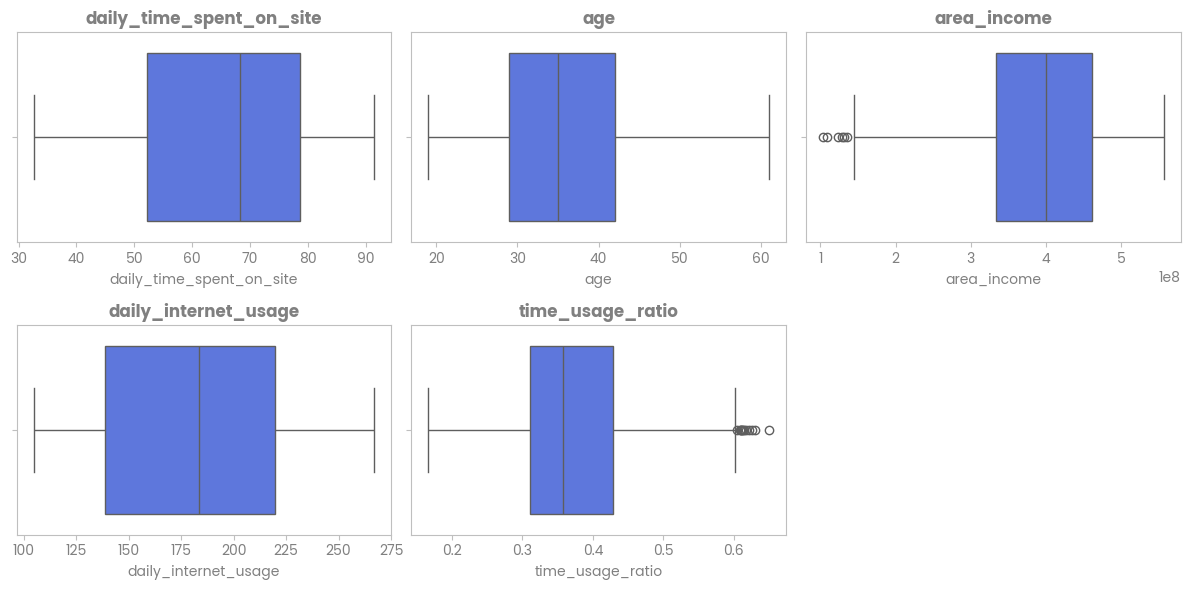

In [79]:
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(4*cols_per_row, 3*rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=X_train[col], ax=axes[i])
    axes[i].set_title(col, fontweight='bold')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [80]:
summary = []

for col in num_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(X_train)) * 100

    summary.append({
        'column': col,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_count': outlier_count,
        'outlier_percentage': outlier_pct
    })

    for df in [X_train, X_test]:
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

summary_df = pd.DataFrame(summary)
pd.options.display.float_format = '{:,.2f}'.format
display(summary_df)

,column,lower_bound,upper_bound,outlier_count,outlier_percentage
0,daily_time_spent_on_site,12.54,118.19,0,0.00
1,age,9.50,61.50,0,0.00
2,area_income,"142,296,603.75","651,793,913.75",6,0.86
3,daily_internet_usage,17.50,340.71,0,0.00
4,time_usage_ratio,0.13,0.60,12,1.71


## **3.5. Encode Features**

In [81]:
X_train_cb = X_train.copy()
X_train_gen = X_train.copy()

X_test_cb = X_test.copy()
X_test_gen = X_test.copy()

In [82]:
# Convert target variable to numeric
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

In [83]:
# Encode binary categorical variables
X_train_gen['male'] = X_train_gen['male'].map({'Laki-Laki': 1, 'Perempuan': 0})
X_test_gen['male'] = X_test_gen['male'].map({'Laki-Laki': 1, 'Perempuan': 0})

In [84]:
# Frequency Encoding
freq_cols = ["city", "province", "category"]

for col in freq_cols:
    freq_map = X_train_gen[col].value_counts().to_dict()
    X_train_gen[col + "_freq"] = X_train_gen[col].map(freq_map)
    X_test_gen[col + "_freq"] = X_test_gen[col].map(freq_map).fillna(0)

X_train_gen = X_train_gen.drop(columns=freq_cols)
X_test_gen = X_test_gen.drop(columns=freq_cols)

In [85]:
# Ordinal Encoding
ordinal_cols = ["age_group"]
ordinal_categories = [['28–32', '18–28', '44–61', '37–44', '32–37']]

ord_enc = OrdinalEncoder(categories=ordinal_categories)

X_train_gen[ordinal_cols] = ord_enc.fit_transform(X_train_gen[ordinal_cols])
X_test_gen[ordinal_cols] = ord_enc.transform(X_test_gen[ordinal_cols])

X_train_cb[ordinal_cols] = ord_enc.fit_transform(X_train_cb[ordinal_cols])
X_test_cb[ordinal_cols] = ord_enc.transform(X_test_cb[ordinal_cols])

In [86]:
# One Hot Encoding
ohe_cols = ["day_of_week"]
ohe = OneHotEncoder(sparse_output=False, drop="first")
ohe_array_train = ohe.fit_transform(X_train_gen[ohe_cols])
ohe_df = pd.DataFrame(ohe_array_train, columns=ohe.get_feature_names_out(ohe_cols), index=X_train_gen.index)

X_train_gen = pd.concat([X_train_gen.drop(columns=ohe_cols), ohe_df], axis=1)

ohe_array_test = ohe.transform(X_test_gen[ohe_cols])
ohe_df_test = pd.DataFrame(ohe_array_test, columns=ohe.get_feature_names_out(ohe_cols), index=X_test_gen.index)

X_test_gen = pd.concat([X_test_gen.drop(columns=ohe_cols), ohe_df_test], axis=1)

## **3.6. Scale Features**

In [87]:
scaler = StandardScaler()

scaler.fit(X_train_gen[num_cols])

X_train_gen[num_cols] = scaler.transform(X_train_gen[num_cols])
X_train_cb[num_cols] = scaler.transform(X_train_cb[num_cols])
X_test_gen[num_cols]  = scaler.transform(X_test_gen[num_cols])
X_test_cb[num_cols]  = scaler.transform(X_test_cb[num_cols])

In [88]:
display(X_train_gen[num_cols].describe().loc[['min', 'max']])

,daily_time_spent_on_site,age,area_income,daily_internet_usage,time_usage_ratio
min,-2.08,-1.95,-2.66,-1.73,-2.16
max,1.69,2.84,1.82,1.98,2.49


## **3.7. Check Class Imbalance**

In [89]:
print(f"Target distribution in train set: {y_train.value_counts().to_dict()}")
print(f"Target distribution in test set: {y_test.value_counts().to_dict()}")

Target distribution in train set: {1: 350, 0: 350}
Target distribution in test set: {1: 150, 0: 150}


## **3.8. Feature Selection**

In [90]:
X_train_ln = X_train_gen.copy()

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_ln.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_ln.values, i) for i in range(X_train_ln.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

                     feature   VIF
10             category_freq 16.18
3       daily_internet_usage 14.85
0   daily_time_spent_on_site 14.26
5           time_usage_ratio 13.83
8                  city_freq  9.53
9              province_freq  4.63
7                       hour  3.81
6                  age_group  3.73
14             day_of_week_4  2.13
16             day_of_week_6  2.10
13             day_of_week_3  2.09
12             day_of_week_2  2.06
4                       male  1.99
15             day_of_week_5  1.93
11             day_of_week_1  1.80
1                        age  1.35
2                area_income  1.17


In [91]:
X_train_ln = X_train_ln.drop(columns=["category_freq", 'daily_internet_usage', 'city_freq', 'age_group', 'hour', 'province_freq'])

In [92]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_ln.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_ln.values, i) for i in range(X_train_ln.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

                     feature  VIF
3                       male 1.75
0   daily_time_spent_on_site 1.67
4           time_usage_ratio 1.41
1                        age 1.19
6              day_of_week_2 1.19
7              day_of_week_3 1.16
2                area_income 1.16
8              day_of_week_4 1.13
10             day_of_week_6 1.12
5              day_of_week_1 1.09
9              day_of_week_5 1.08


In [93]:
cat_features = ['male', 'city', 'province', 'category', 'age_group', 'hour', 'day_of_week']
for col in cat_features:
    X_train_cb[col] = X_train_cb[col].astype(str)

feature_names = X_train_gen.columns
feature_names_cb = X_train_cb.columns
feature_names_ln = X_train_ln.columns
results = []

def select_by_cumulative_importance(importances, feature_names, threshold=0.95):
    sorted_idx = np.argsort(importances)[::-1]
    cum_importance = np.cumsum(importances[sorted_idx])
    n_selected = np.argmax(cum_importance >= threshold) + 1
    return feature_names[sorted_idx[:n_selected]]

# Logistic Regression (L1)
lr = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
lr.fit(X_train_ln, y_train)
model = SelectFromModel(lr, prefit=True)
selected = feature_names_ln[model.get_support()]
results.append(("Logistic Regression", list(selected)))

# SVM (Linear + L1)
svm = LinearSVC(penalty="l1", dual=False, random_state=42)
svm.fit(X_train_ln, y_train)
model = SelectFromModel(svm, prefit=True)
selected = feature_names_ln[model.get_support()]
results.append(("SVM", list(selected)))

# Naive Bayes (mutual info)
selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(X_train_gen, y_train)
selected = feature_names[selector.get_support()]
results.append(("Naive Bayes", list(selected)))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_gen, y_train)
selected = select_by_cumulative_importance(rf.feature_importances_, feature_names)
results.append(("Random Forest", list(selected)))

# Extra Trees
et = ExtraTreesClassifier(random_state=42)
et.fit(X_train_gen, y_train)
selected = select_by_cumulative_importance(et.feature_importances_, feature_names)
results.append(("Extra Trees", list(selected)))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_gen, y_train)
selected = select_by_cumulative_importance(gb.feature_importances_, feature_names)
results.append(("Gradient Boosting", list(selected)))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_gen, y_train)
selected = select_by_cumulative_importance(xgb.feature_importances_, feature_names)
results.append(("XGBoost", list(selected)))

# CatBoost
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train_cb, y_train, cat_features=cat_features)
selected = select_by_cumulative_importance(cat.feature_importances_, feature_names_cb)
results.append(("CatBoost", list(selected)))

# KNN → semua fitur
results.append(("KNN", list(feature_names_ln)))

# Simpan ke CSV
df_results = pd.DataFrame(results, columns=["Model", "Selected_Features"])
df_results.to_csv("selected_features.csv", index=False)

## **3.9. Save Datasets**

In [94]:
train_gen = X_train_gen.copy()
train_gen['clicked_on_ad'] = y_train

test_gen = X_test_gen.copy()
test_gen['clicked_on_ad'] = y_test

train_gen.to_csv("train_gen.csv", index=False)
test_gen.to_csv("test_gen.csv", index=False)

train_cb = X_train_cb.copy()
train_cb['clicked_on_ad'] = y_train

test_cb = X_test_cb.copy()
test_cb['clicked_on_ad'] = y_test

train_cb.to_csv("train_cb.csv", index=False)
test_cb.to_csv("test_cb.csv", index=False)